## 通过神经网络预测房价
在这个项目中，我们希望能够构建神经网络来预测房屋的价格

首先，我们导入一些必要的库

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline

读取训练集和测试集的数据

In [38]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

可以具体看看前面 5 个训练集长什么样子，可以看到，前面都是这个房屋的属性，最后是房屋的价格

In [39]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


接着我们可以看看训练集和测试集分别有多少个样本

In [40]:
print('一共有 {} 个训练集样本'.format(train.shape[0]))
print('一共有 {} 个测试集样本'.format(test.shape[0]))

一共有 1314 个训练集样本
一共有 146 个测试集样本


接着我们开始对数据进行处理，首先我们取出**第二个特征**到**倒数第二个特征**，这些特征作为我们神经网络的输入特征

In [41]:
all_features = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                          test.loc[:, 'MSSubClass':'SaleCondition']))

接着我们需要进行数据标准化，对于所有的数值特征，我们都会减去均值，除以方差

In [42]:
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index # 取出所有的数值特征

# 减去均值，除以方差
all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x: (x - x.mean()) 
                                                                / (x.std()))

如果你仔细看看上面的特征，你会发现，除了数值特征之外，还有很多非数值特征，这些特征我们没有办法将其转换成数值表示，所以我们通过 pandas 的内置函数将其转换成种类表示

比如 **MSZoning** 有两种可能，一种是 RL，一种是 RM，那么我们就将这个特征变成两个新的特征，RL 和 RM，如果这个数据在 **MSZoning** 上是 RL，那么 RL 取 1，RM 取 0；反之如果这个特征是 RM，那么 RL 取 0，RM 取 1.

| RL | RM |
|-|-|
| 0 | 1 |
| 1 | 0 |

In [43]:
all_features = pd.get_dummies(all_features, dummy_na=True)

除此之外，我们会发现整个数据中有一些丢失数据，这些丢失数据都是 'NA'，我们没有办法将这些数据输入到网络中，所以需要对这些丢失数据进行赋值，这里我们将数据的均值填入到丢失数据中

In [44]:
all_features = all_features.fillna(all_features.mean())

前面我们已经做好了数据的预处理，下面我们将所有的训练集和验证集都取出成为一个 numpy 的数组

In [45]:
num_train = train.shape[0]

train_features = all_features[:num_train].values.astype(np.float32)
test_features = all_features[num_train:].values.astype(np.float32)

train_labels = train.SalePrice.values[:, None].astype(np.float32)
test_labels = test.SalePrice.values[:, None].astype(np.float32)

下面需要你来填写代码完成本次的项目

**注意：你只需要完成下面 todo 的部分**

In [46]:
from torch import nn

def get_model():
    # todo: 使用 nn.Sequential 来构造多层神经网络，注意第一层的输入
    model = nn.Sequential(
        nn.Linear(331, 200),
        nn.ReLU(),
        nn.Linear(200, 150),
        nn.ReLU(),
        nn.Linear(150, 100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    return model

In [47]:
# 可以调整的超参

batch_size = 32
epochs = 100
use_gpu = False
lr = 0.0002
weight_decay = 10

In [48]:
# todo: 使用 mse 作为 loss 函数
if use_gpu:
    criterion = nn.MSELoss().cuda()
else:
    criterion = nn.MSELoss()

在评估模型的时候，为了保证大的价格和小的价格对模型都有着近似相同的影响，我们不会直接使用前面定义的均方误差作为最后的评价函数，我们会对预测的价格和真实的价格取 log，然后计算他们之间均方误差的平方根来作为评价指标，这里的指标我们已经在 `utils.py` 中实现了，感兴趣的同学可以去看看。

In [49]:
import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from utils import get_rmse_log

In [50]:
# todo: 将所有的 feature 和 label 都转成 torch 的 Tensor
train_features = torch.from_numpy(train_features).float()
train_labels = torch.from_numpy(train_labels).float()
test_features = torch.from_numpy(test_features).float()
test_labels = torch.from_numpy(test_labels).float()

In [51]:
# 构建一个数据的迭代器
def get_data(x, y, batch_size, shuffle):
    dataset = TensorDataset(x, y)
    return DataLoader(dataset, batch_size, shuffle=shuffle, num_workers=4)

In [52]:
def train_model(model, x_train, y_train, x_valid, y_valid, epochs, lr, weight_decay):
    metric_log = dict()
    metric_log['train_loss'] = list()
    if x_valid is not None:
        metric_log['valid_loss'] = list()
    
    train_data = get_data(x_train, y_train, batch_size, True)
    if x_valid is not None:
        valid_data = get_data(x_valid, y_valid, batch_size, False)
    else:
        valid_data = None
    
    # todo: 构建优化器，推荐使用 Adam，也可以尝试一下别的优化器
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    if use_gpu:
        model = model.cuda()
    
    for e in range(epochs):
        # 训练模型
        running_loss = 0
        model.train()
        for data in train_data:
            x, y = data
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
            x = Variable(x)
            y = Variable(y)
            
            # todo: 前向传播
            out = model(x)
            
            # todo: 计算 loss
            loss = criterion(out, y)
            
            # todo: 反向传播，更新参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss
           
        
        metric_log['train_loss'].append(get_rmse_log(model, x_train, y_train, use_gpu))
        
        # 测试模型
        if x_valid is not None:
            metric_log['valid_loss'].append(get_rmse_log(model, x_valid, y_valid, use_gpu))
            print_str = 'epoch: {}, train loss: {:.3f}, valid loss: {:.3f}'\
            .format(e+1, metric_log['train_loss'][-1], metric_log['valid_loss'][-1])
        else:
            print_str = 'epoch: {}, train loss: {:.3f}'.format(e+1, metric_log['train_loss'][-1])
        if (e + 1) % 10 == 0:
            print(print_str)
            # print()

    # =======不要修改这里的内容========
    # 可视化
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    plt.plot(metric_log['train_loss'], color='red', label='train')
    if valid_data is not None:
        plt.plot(metric_log['valid_loss'], color='blue', label='valid')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

当我们构建好了训练的过程，下面就开始了不断地调参尝试，最后得到一个效果最好的模型

epoch: 10, train loss: 0.201, valid loss: 0.206
epoch: 20, train loss: 0.167, valid loss: 0.159
epoch: 30, train loss: 0.153, valid loss: 0.144
epoch: 40, train loss: 0.143, valid loss: 0.140
epoch: 50, train loss: 0.138, valid loss: 0.136
epoch: 60, train loss: 0.134, valid loss: 0.135
epoch: 70, train loss: 0.132, valid loss: 0.137
epoch: 80, train loss: 0.130, valid loss: 0.136
epoch: 90, train loss: 0.128, valid loss: 0.137
epoch: 100, train loss: 0.128, valid loss: 0.139


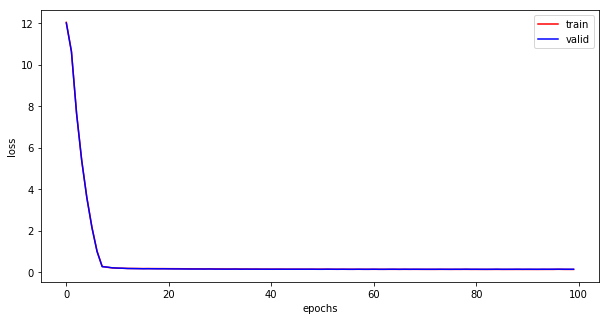

In [53]:
model = get_model()
train_model(model, train_features, train_labels, test_features, test_labels, epochs, lr, weight_decay)